### Instruction to run this notbook:
1- Requirment: matplotlib,pandas,torch,numpy,tqdm

2-change results_dir to where you want the .gif to be stored

3- Run first two cell, and change location of the main folder so we can import odeint.py

4-change the datasets path

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
%cd /content/drive/MyDrive/ProbAI/CNF


/content/drive/MyDrive/ProbAI/CNF


In [3]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib
matplotlib.use('agg')##may need to remove
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from odeint import odeint as od
import odeint
 


In [4]:
results_dir = "/content/drive/MyDrive/ProbAI"
niters = 1000
lr = 1e-3
num_samples = 512
width = 64
hidden_dim = 32
 

In [5]:
#target distribution
#all of our datasets has 500 sample 
def get_batch(num_samples):
    points=data_moons
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(500, 1).type(torch.float32).to(device)

    return(x, logp_diff_t1)

def trace_df_dz(f, z):
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()

In [6]:
import pandas as pd

data_moons = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/two_moons.csv')
two_blobs = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/two_blobs.csv')
boomerang = pd.read_csv('/content/drive/MyDrive/ProbAI/datasets/boomerang.csv')

data_moons=data_moons.to_numpy()
two_blobs=two_blobs.to_numpy()
boomerang=boomerang.to_numpy()
 
 

In [7]:

    
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


#From the original paper section 4: (We can specify the parameters of a flow as a function of t, making the differential equation f(z(t), t) change with t. This is parameterization is a kind of **hypernetwork** ((Ha et al., 2016)
## Incorporate t as an input to f using HyperNetwork. **Hyper-network allowing f(z(t), t) to change with time**


In [8]:
class HyperNetwork(nn.Module):
 
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]

In [9]:
class CNF(nn.Module):

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)

In [10]:
t0 = 0
t1 = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

func = CNF(in_out_dim=2, hidden_dim=hidden_dim, width=width).to(device)
optimizer = optim.Adam(func.parameters(), lr=lr)
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)
loss_meter = RunningAverageMeter()

for itr in range(1, niters + 1):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(num_samples)

    z_t, logp_diff_t = od(func,(x, logp_diff_t1),torch.tensor([t1, t0]).type(torch.float32).to(device),atol=1e-5,rtol=1e-5,method='dopri5')

    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    loss = -logp_x.mean(0)

    loss.backward()
    optimizer.step()

    loss_meter.update(loss.item())

    print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))


print('Training complete after {} iters.'.format(itr))

Iter: 1, running avg loss: 6.0154
Iter: 2, running avg loss: 6.0116
Iter: 3, running avg loss: 6.0041
Iter: 4, running avg loss: 5.9930
Iter: 5, running avg loss: 5.9784
Iter: 6, running avg loss: 5.9603
Iter: 7, running avg loss: 5.9389
Iter: 8, running avg loss: 5.9141
Iter: 9, running avg loss: 5.8864
Iter: 10, running avg loss: 5.8559
Iter: 11, running avg loss: 5.8230
Iter: 12, running avg loss: 5.7883
Iter: 13, running avg loss: 5.7521
Iter: 14, running avg loss: 5.7150
Iter: 15, running avg loss: 5.6777
Iter: 16, running avg loss: 5.6403
Iter: 17, running avg loss: 5.6033
Iter: 18, running avg loss: 5.5668
Iter: 19, running avg loss: 5.5309
Iter: 20, running avg loss: 5.4954
Iter: 21, running avg loss: 5.4604
Iter: 22, running avg loss: 5.4258
Iter: 23, running avg loss: 5.3914
Iter: 24, running avg loss: 5.3572
Iter: 25, running avg loss: 5.3233
Iter: 26, running avg loss: 5.2896
Iter: 27, running avg loss: 5.2560
Iter: 28, running avg loss: 5.2225
Iter: 29, running avg loss: 5

In [ ]:
viz_samples = 30000
viz_timesteps = 41
target_sample, _ = get_batch(viz_samples)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)
with torch.no_grad():
    # Generate evolution of samples
    z_t0 = p_z0.sample([viz_samples]).to(device)
    logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)

    z_t_samples, _ = od(func,(z_t0, logp_diff_t0),torch.tensor(np.linspace(t0, t1, viz_timesteps)).to(device),atol=1e-5,rtol=1e-5,method='dopri5')

        # Generate evolution of density
    x = np.linspace(-1.5, 2.5, 100)
    y = np.linspace(-1.5, 1.5, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T

    z_t1 = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(device)

    z_t_density, logp_diff_t = od(func,(z_t1, logp_diff_t1),torch.tensor(np.linspace(t1, t0, viz_timesteps)).to(device),atol=1e-5,rtol=1e-5,method='dopri5')

    # Create plots for each timestep
    for (t, z_sample, z_density, logp_diff) in zip(np.linspace(t0, t1, viz_timesteps),z_t_samples, z_t_density, logp_diff_t):
        fig = plt.figure(figsize=(12, 4), dpi=200)
        plt.tight_layout()
        plt.axis('off')
        plt.margins(0, 0)
        fig.suptitle(f'{t:.2f}s')

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title('Target')
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title('Samples')
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title('Log Probability')
        ax3.get_xaxis().set_ticks([])
        ax3.get_yaxis().set_ticks([])

        ax1.hist2d(*target_sample.detach().cpu().numpy().T, bins=300, density=True,range=[[-1.5, 2.5], [-1.5, 1.5]])

        ax2.hist2d(*z_sample.detach().cpu().numpy().T, bins=300, density=True,range=[[-1.5, 2.5], [-1.5, 1.5]])

        logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
        ax3.tricontourf(*z_t1.detach().cpu().numpy().T,np.exp(logp.detach().cpu().numpy()), 200)

        plt.savefig(os.path.join(results_dir, f"cnf-viz-two-moons-{int(t*1000):05d}.jpg"),pad_inches=0.2, bbox_inches='tight')
        plt.close()

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(results_dir, f"cnf-viz-two-moons-*.jpg")))]
    img.save(fp=os.path.join(results_dir, "cnf-viz-two-moons.gif"), format='GIF', append_images=imgs,save_all=True, duration=250, loop=0)

print('Saved visualization animation at {}'.format(os.path.join(results_dir, "cnf-viz-two-moons.gif")))

Saved visualization animation at /content/drive/MyDrive/ProbAI/cnf-viz-two-moons.gif


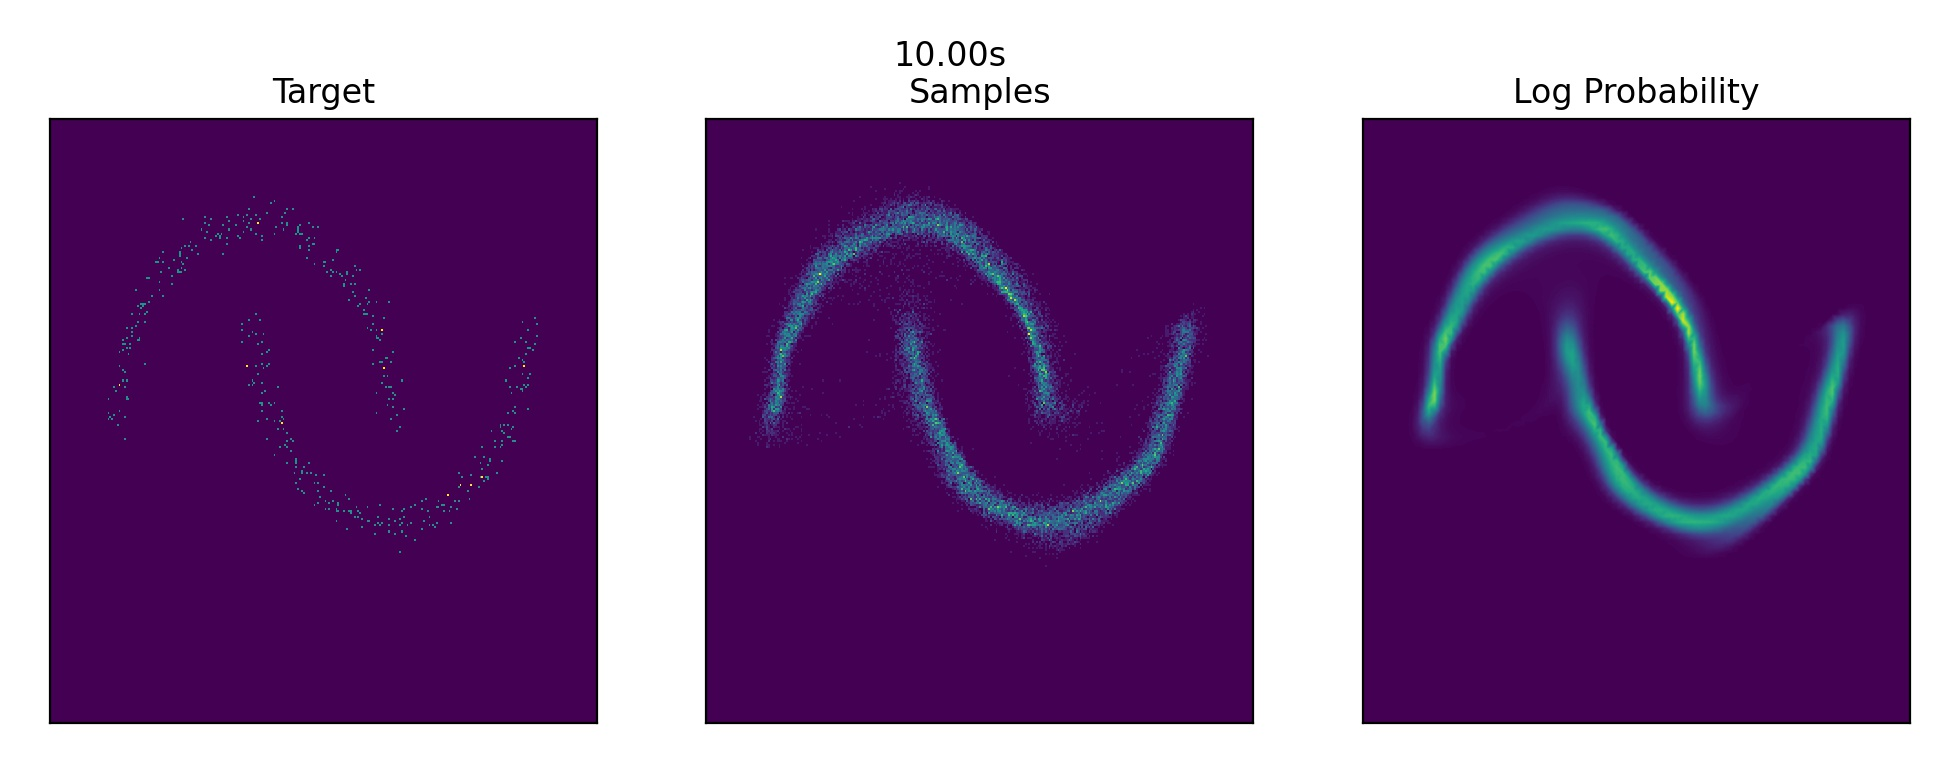

In [34]:
from IPython.display import Image
Image('/content/drive/MyDrive/ProbAI/CNF/cnf-viz-two-moons-10000.jpg')

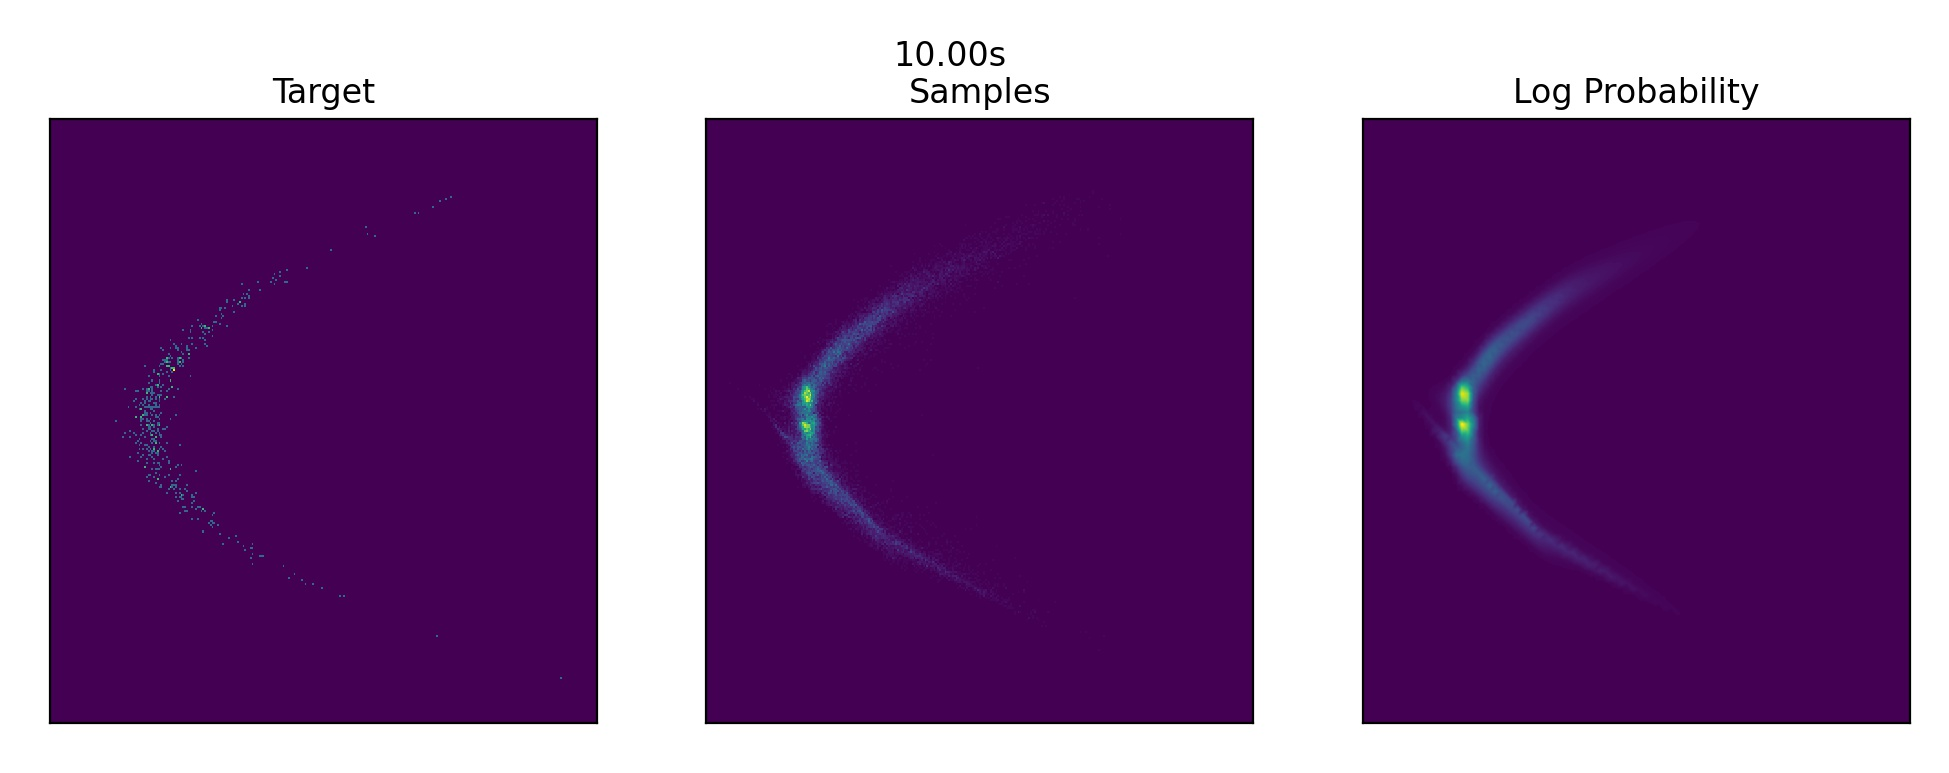

In [36]:
from IPython.display import Image
Image('/content/drive/MyDrive/ProbAI/CNF/cnf-viz-boomerang-10000.jpg')

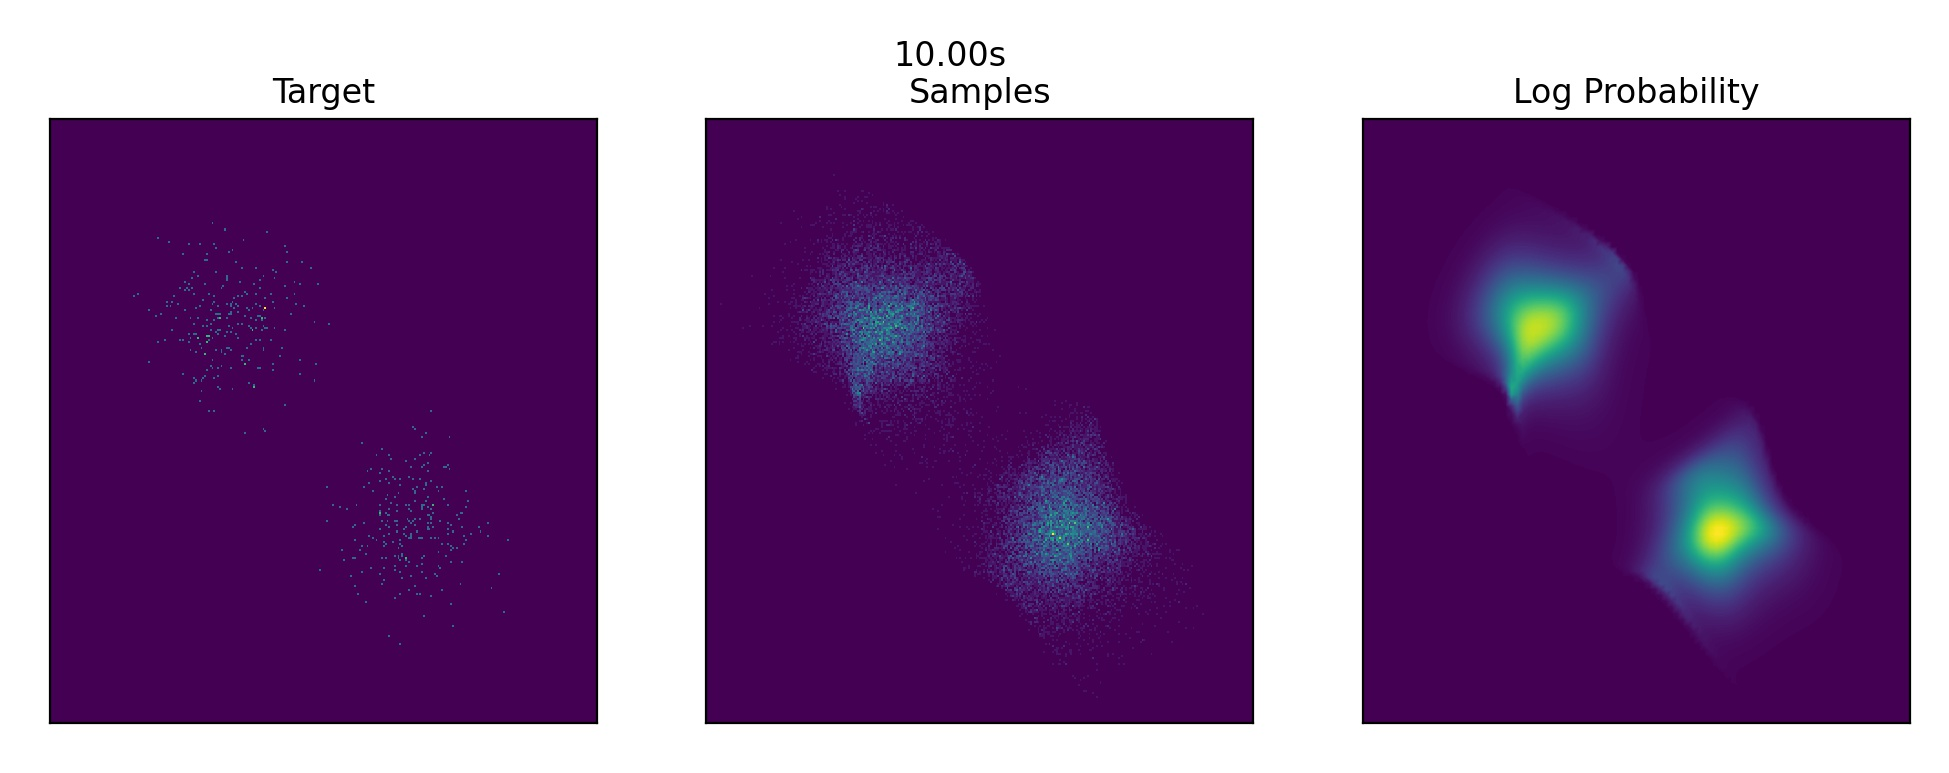

In [35]:
from IPython.display import Image
Image('/content/drive/MyDrive/ProbAI/CNF/cnf-viz-two_blobs-10000.jpg')